In [1]:
!pip install visualkeras seaborn

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet152V2, ResNet101V2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [3]:
tf.keras.backend.clear_session()

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'

In [5]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

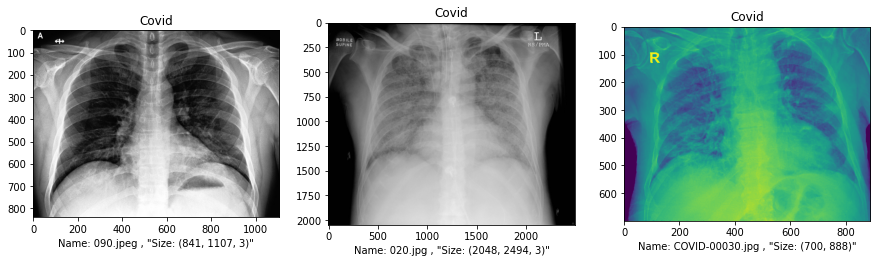

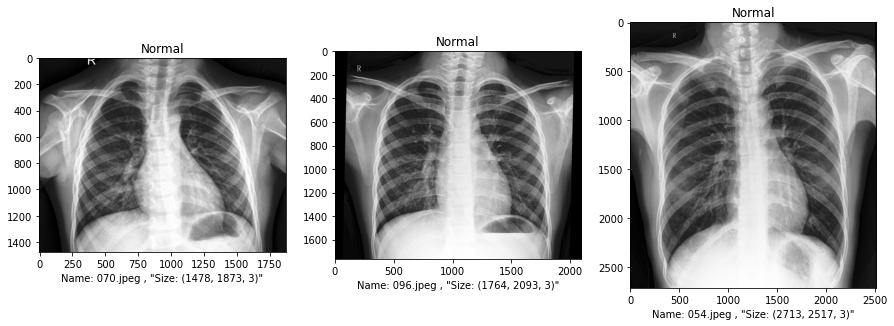

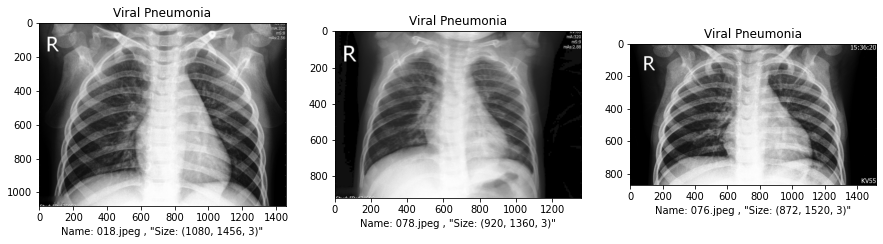

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [9]:
img_size = 512
batch = 16
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory = test_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [10]:
base_model = ResNet101V2(weights='imagenet', include_top=False,
                         input_shape=(img_size, img_size, 3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1024 , activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(512 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512 , activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256 , activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [11]:
!pip install pydot

In [12]:
model.summary() # 205 + 12 = 217 layers

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_out (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 128, 128, 25  1024       ['conv2_block2_out[0][0]']       
 ormalization)                  6)                                                                
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 128, 128, 25  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16384       ['conv2_block3_preact_relu[0][0]'
          

 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 66, 66, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 64, 64, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block1_preact_relu (Acti  (None, 32, 32, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 32, 32, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 32, 32, 256)  589824      ['conv4_block3_2_pad[0][0]']     
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block3_2_relu[0][0]']    
          

 vation)                        )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 32, 32, 256)  262144      ['conv4_block6_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block8_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block8_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block8_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block8_out (Add)         (None, 32, 32, 1024  0           ['conv4_block7_out[0][0]',       
                                )                                 'conv4_block8_3_conv[0][0]']    
                                                                                                  
 conv4_block9_preact_bn (BatchN  (None, 32, 32, 1024  4096       ['conv4_block8_out[0][0]']       
 ormalizat

 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_pad (ZeroPaddi  (None, 34, 34, 256)  0          ['conv4_block11_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 32, 32, 256)  589824      ['conv4_block11_2_pad[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block13_out (Add)        (None, 32, 32, 1024  0           ['conv4_block12_out[0][0]',      
                                )                                 'conv4_block13_3_conv[0][0]']   
                                                                                                  
 conv4_block14_preact_bn (Batch  (None, 32, 32, 1024  4096       ['conv4_block13_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block14_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block14_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block14_preact_relu[0][0]
          

 ng2D)                                                                                            
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 32, 32, 256)  589824      ['conv4_block16_2_pad[0][0]']    
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block16_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block19_preact_relu (Act  (None, 32, 32, 1024  0          ['conv4_block19_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, 32, 32, 256)  262144      ['conv4_block19_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block19_1_bn (BatchNorma  (None, 32, 32, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block21_2_relu (Activati  (None, 32, 32, 256)  0          ['conv4_block21_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, 32, 32, 1024  263168      ['conv4_block21_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block21_out (Add)        (None, 32, 32, 1024  0           ['conv4_block20_out[0][0]',      
                                )                                 'conv4_block21_3_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv5_block1_1_conv (Conv2D)   (None, 16, 16, 512)  524288      ['conv5_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_pad (ZeroPaddin  (None, 18, 18, 512)  0          ['conv5_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block3_out (Add)         (None, 16, 16, 2048  0           ['conv5_block2_out[0][0]',       
                                )                                 'conv5_block3_3_conv[0][0]']    
                                                                                                  
 post_bn (

In [13]:
plot_model(model, to_file='./images/resnet101_model.png', show_shapes=True, show_layer_names=True)

In [14]:
visualkeras.layered_view(model, legend=True)

In [15]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1), 
             ModelCheckpoint('./models/resnet101_model.h5', save_best_only=True)]

In [16]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
DISABLE_GPU = True
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [18]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 29s 1s/step - loss: 1.9881 - accuracy: 0.3904 - val_loss: 1.0658 - val_accuracy: 0.4697
Epoch 2/100
16/16 [==============================] - 19s 1s/step - loss: 1.9201 - accuracy: 0.3984 - val_loss: 1.0427 - val_accuracy: 0.4848
Epoch 3/100
16/16 [==============================] - 19s 1s/step - loss: 1.5101 - accuracy: 0.4343 - val_loss: 1.0469 - val_accuracy: 0.5152
Epoch 4/100
16/16 [==============================] - 19s 1s/step - loss: 1.2707 - accuracy: 0.4382 - val_loss: 0.9898 - val_accuracy: 0.6515
Epoch 5/100
16/16 [==============================] - 19s 1s/step - loss: 1.1462 - accuracy: 0.4263 - val_loss: 0.9207 - val_accuracy: 0.6515
Epoch 6/100
16/16 [==============================] - 19s 1s/step - loss: 0.9352 - accuracy: 0.5936 - val_loss: 0.7813 - val_accuracy: 0.6818
Epoch 7/100
16/16 [==============================] - 19s 1s/step - loss: 0.8522 - accuracy: 0.5538 - val_loss: 0.6307 - val_accuracy: 0.5909
Epoch 8/100
1

In [19]:
model = load_model('./models/resnet101_model.h5')

In [20]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

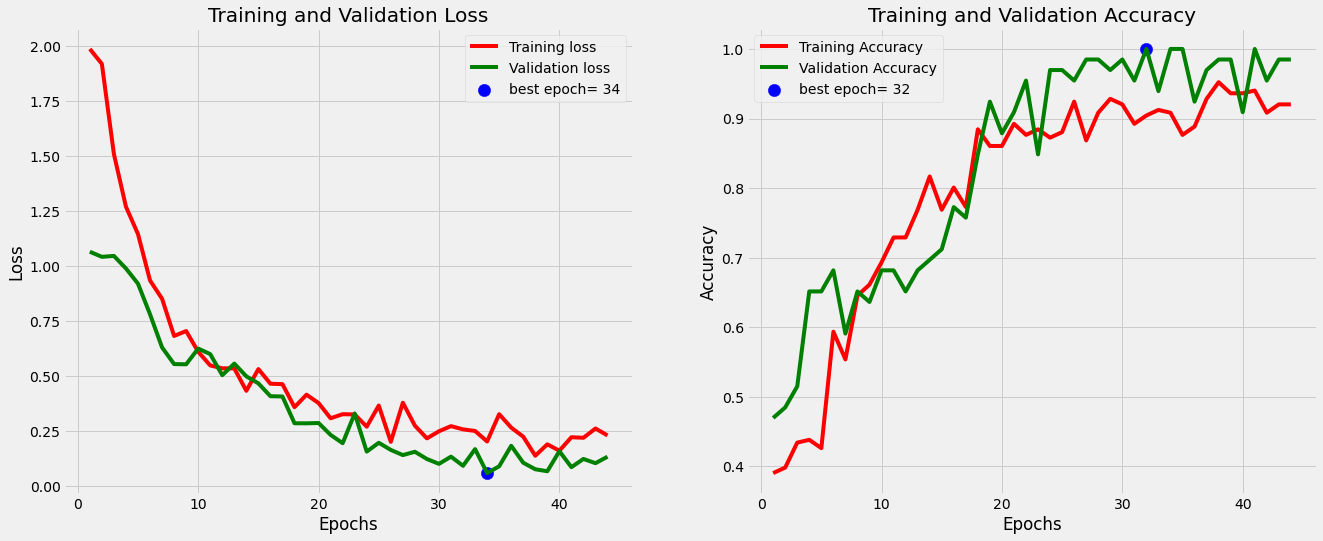

In [21]:
tr_plot(history, 0)

In [22]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 5s 52ms/step - loss: 0.0593 - accuracy: 1.0000
Loss: 5.926
Accuracy: 100.000


In [23]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [24]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [25]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('./images/con_mat.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [26]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [27]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[26  0  0]
 [ 0 20  0]
 [ 0  0 20]]


F1 Score: 1.0


                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      1.00      1.00        20
Viral Pneumonia       1.00      1.00      1.00        20

       accuracy                           1.00        66
      macro avg       1.00      1.00      1.00        66
   weighted avg       1.00      1.00      1.00        66



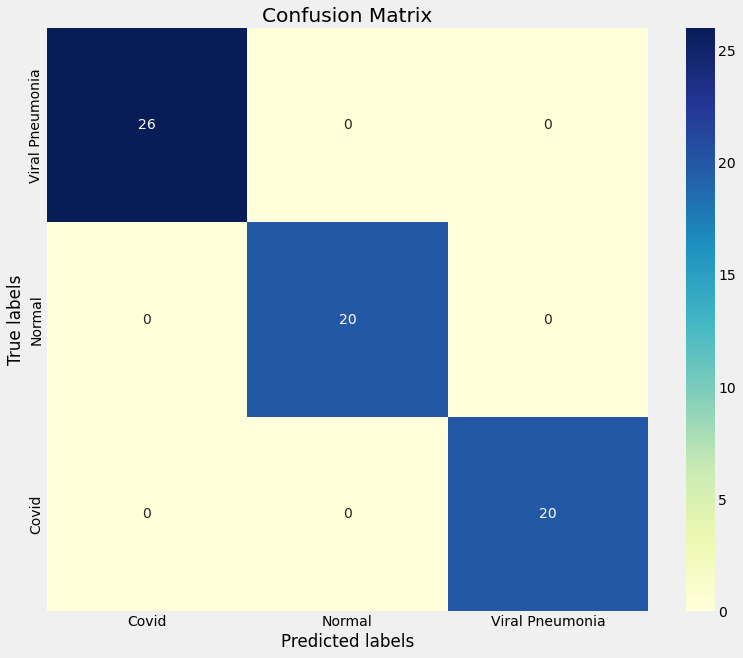

In [28]:
cal_score(model, plot=True)